In [1]:
from google.colab import drive
drive.mount('./mydrive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
pwd

'/content'

In [ ]:
ls

mydrive/  sample_data/


In [ ]:
cd mydrive

/content/mydrive


In [ ]:
cd MyDrive

/content/mydrive/MyDrive


In [ ]:
cd brainimages/

/content/mydrive/MyDrive/brainimages


In [27]:
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, initializers, regularizers, metrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   horizontal_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=5,
                                   shear_range=0.7,
                                   zoom_range=[0.9, 2],
                                   vertical_flip = True,
                                   fill_mode='nearest')

In [29]:
train_generator = train_datagen.flow_from_directory('data/brainimages/train',
                                  target_size=(150,150),
                                  batch_size=5,
                                  class_mode='binary')

Found 160 images belonging to 2 classes.


In [30]:
train_generator.next()[1].shape

(5,)

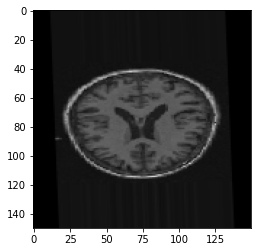

In [31]:
train_generator.next()[0][0].shape
plt.imshow(train_generator.next()[0][0])

In [32]:
test_dategen = ImageDataGenerator(rescale=1./255)

In [39]:
test_generator = test_dategen.flow_from_directory(
    'data/brainimages/train',
    target_size=(150,150),
    batch_size=5,
    class_mode='binary'
)

Found 160 images belonging to 2 classes.


In [40]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 activation_5 (Activation)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_6 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                  

In [41]:
# y(label) : binary
# abnorbal, normal : 0, 1

# y(label) : one_hot
# normal : [1, 0]
# abnormal : [0, 1]

# y(label) : 0, 1, 2, 3 ... => 'sqarse_categorical_crossentropy'

In [42]:
adam = optimizers.Adam(learning_rate=0.0002)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [44]:
# fit_generator => fit
# x,y 나누지 않고 파일 이름에 따라서 자동 라벨링
hist = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data = test_generator,
    validation_steps = 20
)

Epoch 1/20
100/100 [==============================] - 2s 15ms/step - loss: 0.6864 - accuracy: 0.5500 - val_loss: 0.6916 - val_accuracy: 0.5000


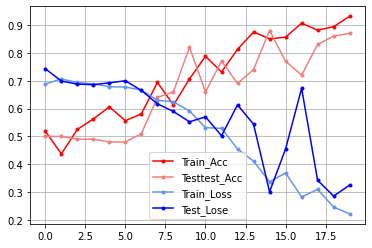

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
x_len = np.arange(len(loss))
plt.plot(x_len, acc, marker='.', c='red', label='Train_Acc')
plt.plot(x_len, val_acc, marker='.', c='lightcoral', label='Testtest_Acc')
plt.plot(x_len, loss, marker='.', c='cornflowerblue', label='Train_Loss')
plt.plot(x_len, val_loss, marker='.', c='blue', label='Test_Lose')

plt.legend()
plt.grid()
plt.show()

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
transfer_model = VGG16(weights ='imagenet', include_top=False, input_shape=(150,150,3))
transfer_model.trainable = False
transfer_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
finetune_model = Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64, activation='relu'))
finetune_model.add(Dense(2, activation='softmax'))
finetune_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                524352    
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 15,239,170
Trainable params: 524,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
finetune_model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
hist = finetune_model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    validation_steps=4
)

Epoch 1/50
32/32 [==============================] - 38s 1s/step - loss: 0.7646 - accuracy: 0.6313 - val_loss: 0.4569 - val_accuracy: 0.8000
Epoch 2/50
32/32 [==============================] - 37s 1s/step - loss: 0.3595 - accuracy: 0.8750 - val_loss: 0.3741 - val_accuracy: 0.8500
Epoch 3/50
32/32 [==============================] - 37s 1s/step - loss: 0.3109 - accuracy: 0.8875 - val_loss: 0.5968 - val_accuracy: 0.7500
Epoch 4/50
32/32 [==============================] - 37s 1s/step - loss: 0.2266 - accuracy: 0.9187 - val_loss: 0.2878 - val_accuracy: 0.8500
Epoch 5/50
32/32 [==============================] - 37s 1s/step - loss: 0.1981 - accuracy: 0.9625 - val_loss: 0.6115 - val_accuracy: 0.7500
Epoch 6/50
32/32 [==============================] - 37s 1s/step - loss: 0.1892 - accuracy: 0.9500 - val_loss: 0.2136 - val_accuracy: 0.9000
Epoch 7/50
32/32 [==============================] - 36s 1s/step - loss: 0.1909 - accuracy: 0.9250 - val_loss: 0.2390 - val_accuracy: 0.9000
Epoch 8/50
32/32 [==